In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path

In [4]:
BASE_PATH = Path(os.path.abspath('')).parent.parent.parent
sys.path.append(str(BASE_PATH))

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np

import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# plt.style.use(['science','ieee'])
# plt.style.use(['science','nature'])

In [15]:
portfolio = pd.read_csv('sp_portfolio_2025_01_12.csv')
portfolio = portfolio.fillna(0.)
portfolio["Date"] = pd.to_datetime(portfolio["Date"], utc=True)#.dt.date
# portfolio = portfolio[portfolio.Date <= datetime.date(2024, 8, 2)]
portfolio = portfolio.set_index("Date")
portfolio = portfolio.astype(float)
# portfolio = portfolio.drop(columns=['TIA-USD', 'OP-USD', 'UNI-USD', 'ARB-USD', 'SHIB-USD'], axis=1)
portfolio = portfolio[portfolio.mean().sort_values(ascending=False).index]

In [16]:
monthly_portfolio = portfolio.resample("M").sum()
monthly_portfolio_std = portfolio.resample("M").std()

returns = pd.DataFrame(monthly_portfolio.mean(), columns=["Return"])
risk = pd.DataFrame(monthly_portfolio_std.std(), columns=["Risk"])

df_risk_return = returns.merge(risk, left_index=True, right_index=True)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_27573/957110852.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_portfolio = portfolio.resample("M").sum()
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_27573/957110852.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_portfolio_std = portfolio.resample("M").std()


In [17]:
import numpy as np

# Generate LaTeX table
table = "\\begin{table}[h]\n"
table += "\\centering\n"
table += "\\begin{tabular}{lcc}\n"
table += "\\hline\n"
table += "Stock Symbol & Mean Daily Returns $\\pm$ Daily Risk \\\\\n"
table += "\\hline\n"
for i in range (len(df_risk_return.index)):
    ticker=df_risk_return.index[i]
    x=df_risk_return.loc[ticker, "Risk"]
    y=df_risk_return.loc[ticker, "Return"]
    table += f"{ticker} & ${y:.3f} \\pm {x:.3f}$ \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\caption{Stocks Daily Risks and Returns}\n"
table += "\\end{table}\n"

print(table)


\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
Stock Symbol & Mean Daily Returns $\pm$ Daily Risk \\
\hline
NVDA & $0.039 \pm 0.012$ \\
ENPH & $0.038 \pm 0.016$ \\
AXON & $0.036 \pm 0.013$ \\
TSLA & $0.034 \pm 0.014$ \\
DECK & $0.032 \pm 0.011$ \\
SMCI & $0.032 \pm 0.024$ \\
FICO & $0.030 \pm 0.012$ \\
FTNT & $0.028 \pm 0.012$ \\
AMD & $0.028 \pm 0.011$ \\
LLY & $0.028 \pm 0.008$ \\
VST & $0.028 \pm 0.012$ \\
AVGO & $0.028 \pm 0.011$ \\
CMG & $0.027 \pm 0.010$ \\
TPL & $0.026 \pm 0.013$ \\
PWR & $0.025 \pm 0.009$ \\
ANET & $0.024 \pm 0.011$ \\
NOW & $0.024 \pm 0.010$ \\
CEG & $0.024 \pm 0.017$ \\
KKR & $0.023 \pm 0.010$ \\
KLAC & $0.023 \pm 0.010$ \\
CDNS & $0.023 \pm 0.009$ \\
PLTR & $0.023 \pm 0.023$ \\
LRCX & $0.023 \pm 0.011$ \\
PANW & $0.023 \pm 0.011$ \\
BX & $0.023 \pm 0.011$ \\
BLDR & $0.022 \pm 0.014$ \\
TT & $0.021 \pm 0.008$ \\
APO & $0.021 \pm 0.012$ \\
JBL & $0.021 \pm 0.011$ \\
CRWD & $0.021 \pm 0.018$ \\
CARR & $0.021 \pm 0.013$ \\
AAPL & $0.021 \pm 0.008$ \\
TD

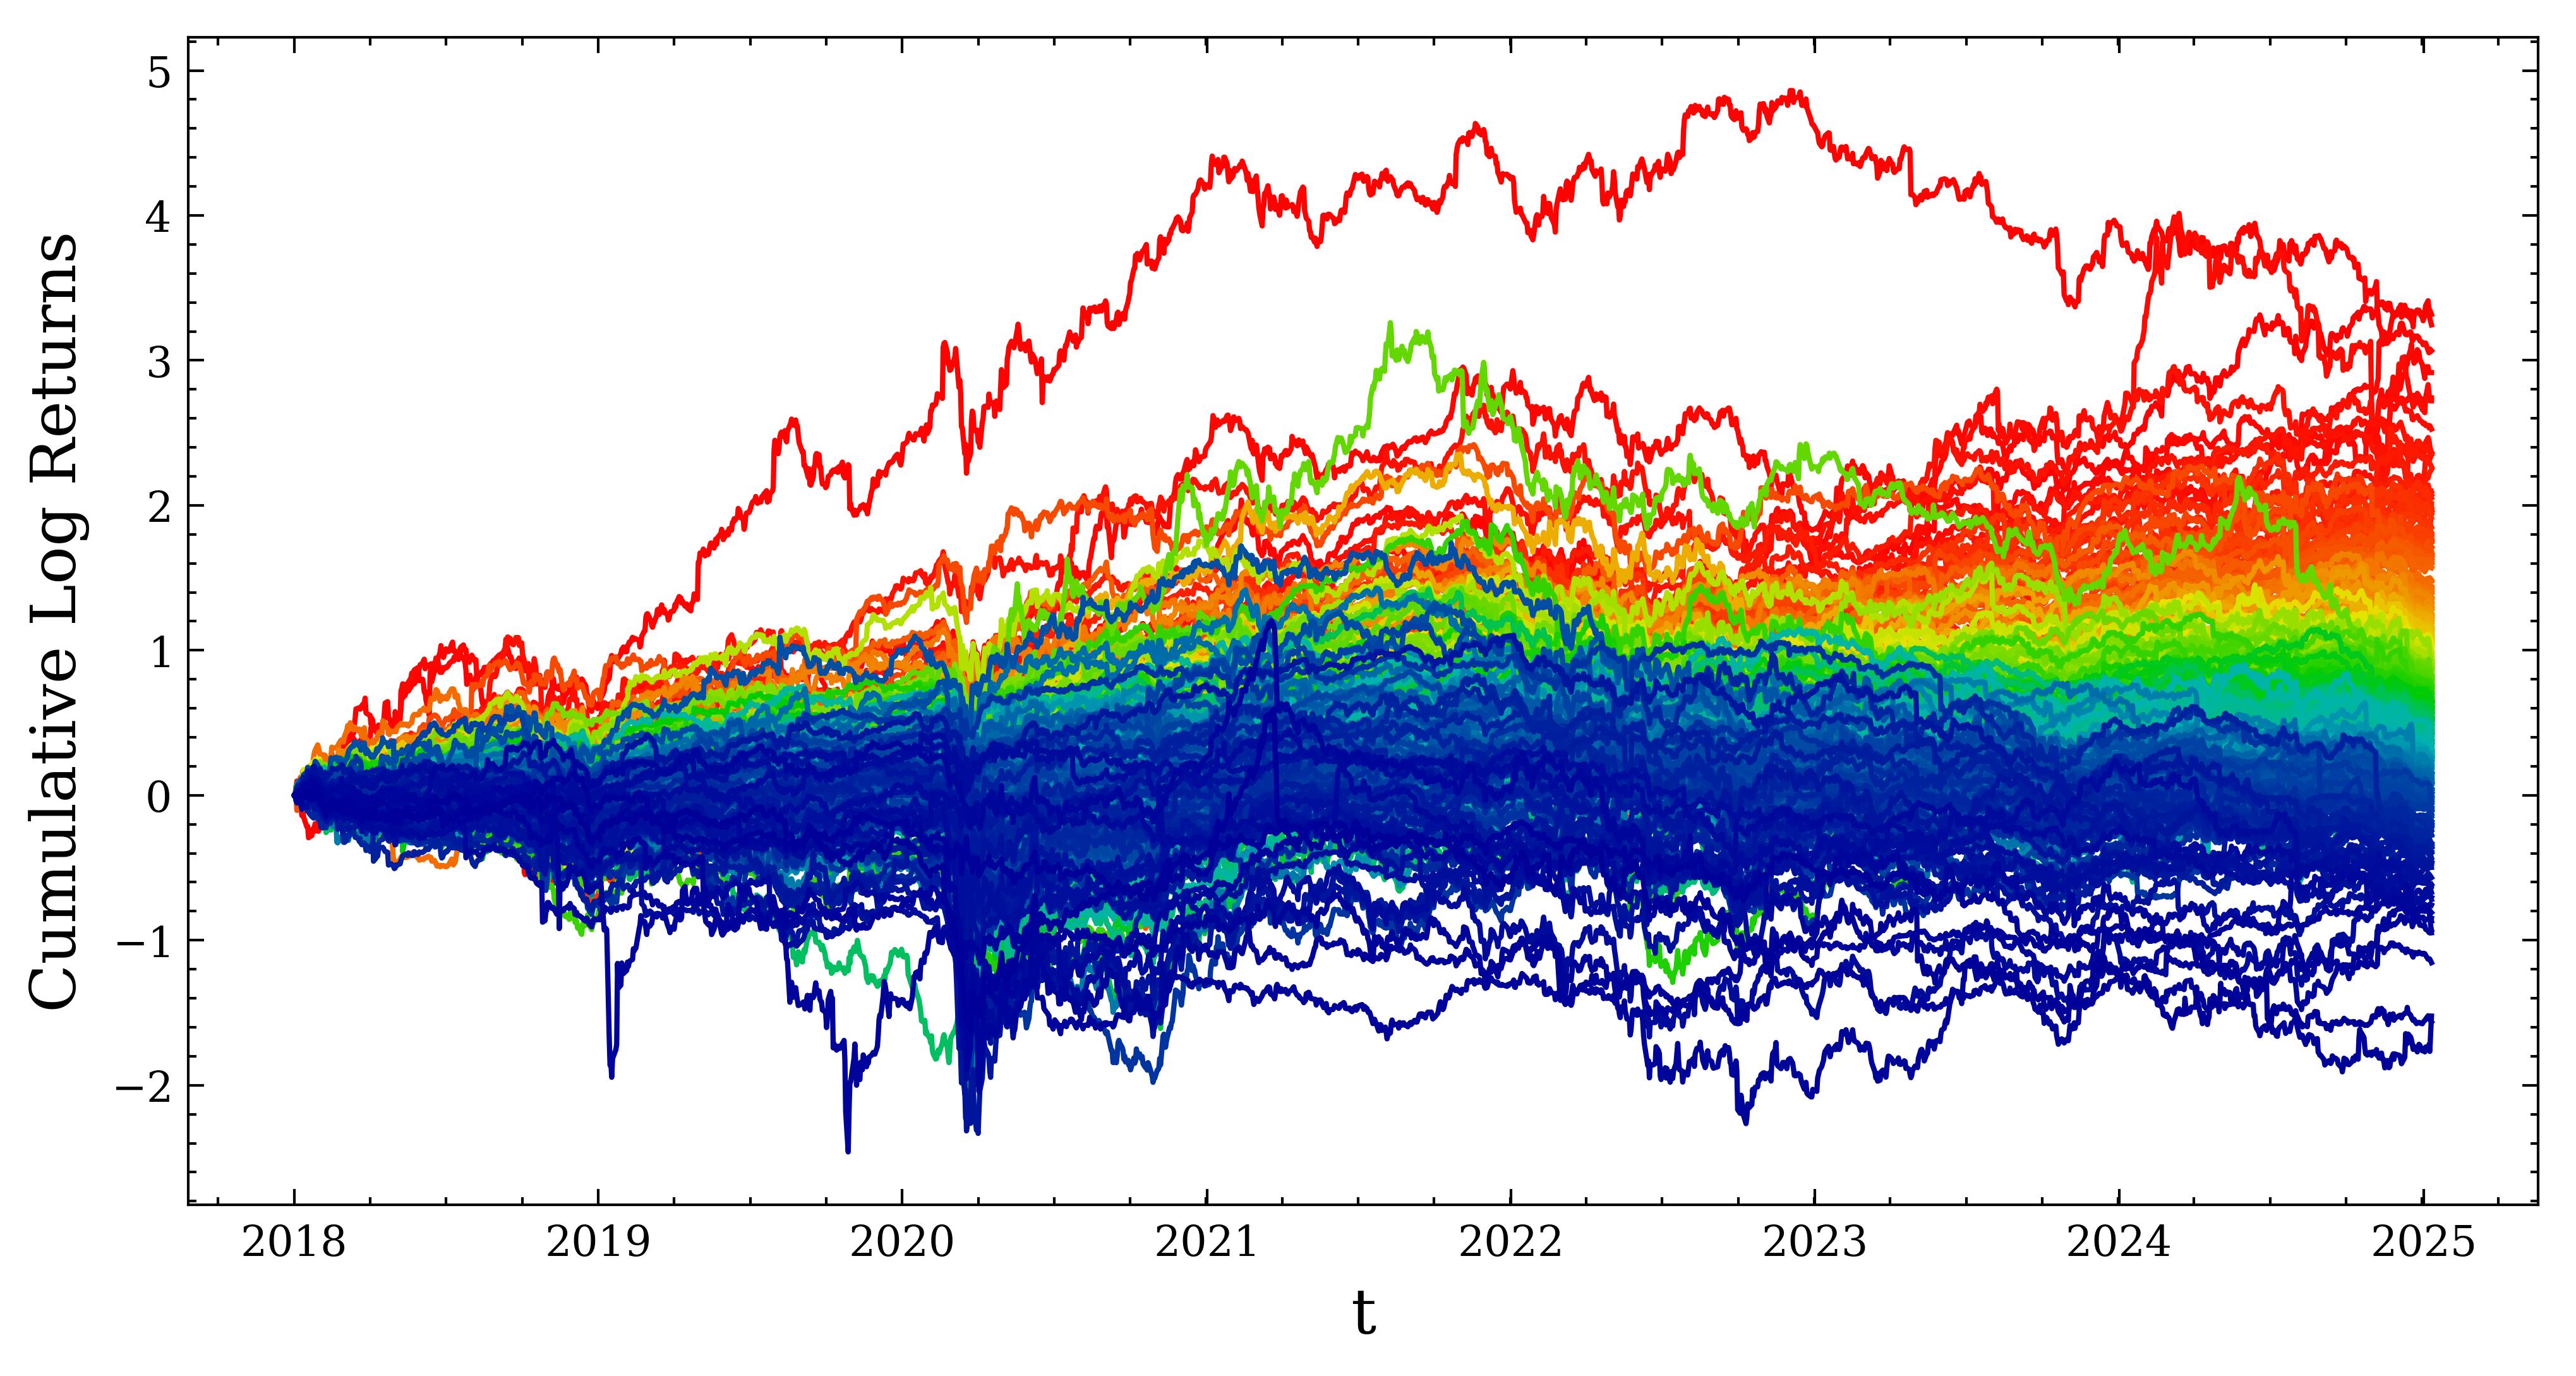

In [18]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(portfolio.columns)))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    i = 0
    for col in portfolio.columns:
        plt.plot(portfolio[col].cumsum(), color=colors[i].rgb, linestyle="-")
        i += 1
#     plt.legend(portfolio.columns, fontsize=4)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('Cumulative Log Returns', fontsize=12)
    plt.savefig('01_classes.jpg', dpi=600)

## 1- Investigating the effect of discount (gamma) in d TS

In [7]:
gamma_vec = np.linspace(0., 1.0, 11)

In [8]:
gamma_vec

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
gamma_hyper_policies = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i]},
        "agents": [],
    }
    for i in range(len(gamma_vec))
}
gamma_hyper_policies.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "w": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
gamma_hyper_policies.update(
    {   
        f"ADTS (mean) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "mean", "w": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
gamma_hyper_policies.update(
    {   
        f"ADTS (max) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "max", "w": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
gamma_hyper_policies.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "n": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
gamma_hyper_policies.update(
    {   
        f"FDSWTS (mean) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "mean", "n": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
gamma_hyper_policies.update(
    {   
        f"FDSWTS (max) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "max", "n": 100},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
# gamma_hyper_policies.update(
#     {   
#         f"Classical TS {i}": {
#             "policy_name": "ThompsonSampling",
#             "args": {"n_arms": portfolio.shape[1]},
#             "agents": [],
#         }
#         for i in range(len(gamma_vec))
#     }
# )

In [10]:
from replay_engines.interface import BacktestInterface, interpolate_colors

gamma_bandit_backtester = BacktestInterface(
    bandit_policies=gamma_hyper_policies,
    n_simulations=30,
    reward_function="WindowedReturnArm",
    reward_function_args=dict(window=60),
    portfolio=portfolio,
)
gamma_bandit_backtester.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 18412.85it/s]
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/min_dsw_ts.py:33: RuntimeWarning: invalid value encountered in scalar divide
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/mean_dsw_ts.py:34: RuntimeWarning: invalid value encountered in scalar divide
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/max_dsw_t

In [11]:
groups = ["ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"]
markers = ["s", "s", "s", "^", "^", "^"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "gamma_vec": gamma_vec,
        "regret": [],
        "reward": [],
    }
    for k, v in gamma_bandit_backtester.bandit_policies.items():
        if g in k:
            results_dict[g]["regret"].append(v["mean_regret"].sum())
            results_dict[g]["reward"].append(v["mean_reward"].sum())

In [14]:
from replay_engines.interface import interpolate_colors

In [13]:
color_start: str = "#1f77b4"
color_end: str = "#ff7f0e"
colors = interpolate_colors(color_start, color_end, len(results_dict))

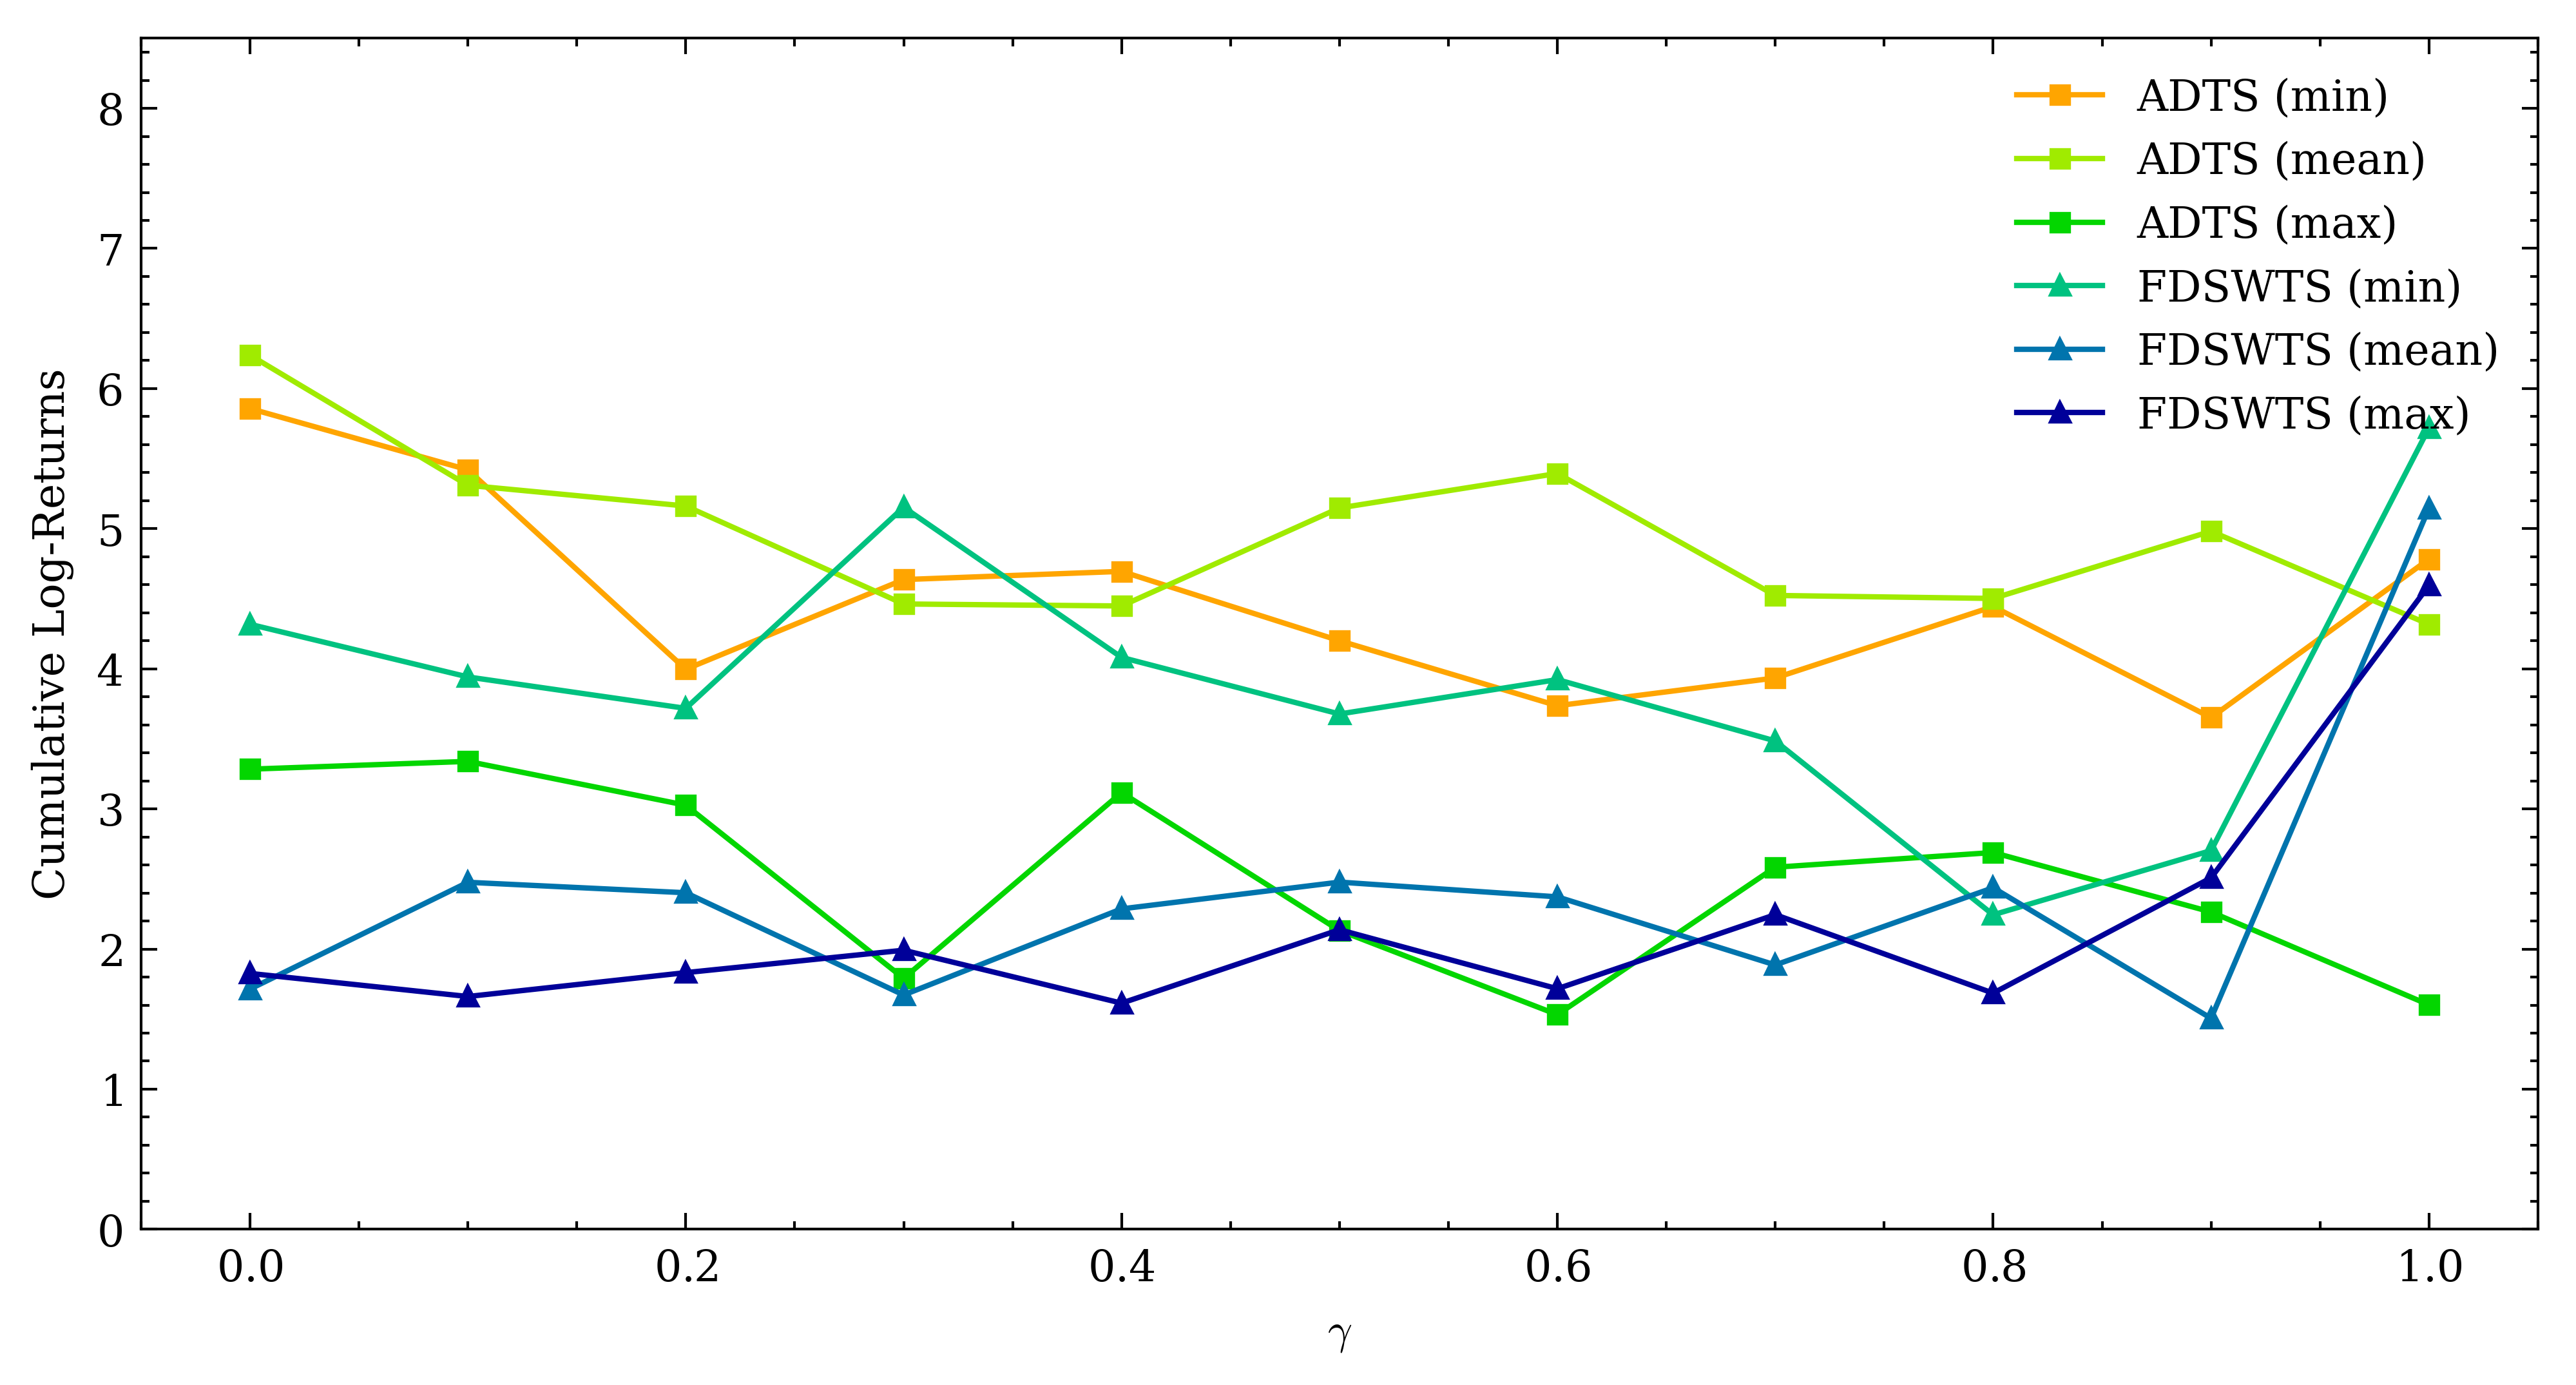

In [21]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)))

x_min = 0.79
x_max = 1.01
y_min = 0.
y_max = 1.5

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(8, 4))
    legend = []
    i = 0
    for policy in results_dict.keys():
        if len(results_dict[policy]['reward']) > 0:
            plt.plot(results_dict[policy]["gamma_vec"], results_dict[policy]["reward"], markers[i], markersize=3, label=policy, color=colors[i].rgb, linestyle="-")
            i+=1    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Cumulative Log-Returns')
    plt.legend(loc='upper right')
    plt.ylim([0, 8.5])
    plt.savefig('04_effect_of_gamma_3.jpg', dpi=600)

## 2- Investigating the window size (w) on sw-d TS

In [26]:
w_vec = np.linspace(0, 300, 13)
w_vec[0]= 1

In [27]:
w_vec

array([  1.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250.,
       275., 300.])

In [28]:
w_polices = {   
    f"ADTS (min) {i}": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "min", "w": int(w_vec[i])},
        "agents": [],
    }
    for i in range(len(w_vec))
}
w_polices.update(
    {   
        f"ADTS (mean) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.6, "f": "mean", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
w_polices.update(
    {   
        f"ADTS (max) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.4, "f": "max", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
w_polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.95, "f": "min", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
w_polices.update(
    {   
        f"FDSWTS (mean) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.95, "f": "mean", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
w_polices.update(
    {   
        f"FDSWTS (max) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.95, "f": "max", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)

In [ ]:
from replay_engines.interface import BacktestInterface

w_bandit_backtester = BacktestInterface(
    bandit_policies=w_polices,
    n_simulations=20,
    reward_function="WindowedReturnArm",
    reward_function_args=dict(window=60),
    portfolio=portfolio,
)
w_bandit_backtester.run()

  9%|█████████████████▌                                                                                                                                                                                  | 7/78 [00:31<07:56,  6.71s/it]IOStream.flush timed out
IOStream.flush timed out█                                                                                                                                                                                | 8/78 [01:18<15:21, 13.17s/it]
 13%|████████████████████████▉                                                                                                                                                                          | 10/78 [02:25<27:01, 23.85s/it]IOStream.flush timed out
IOStream.flush timed out████████▌                                                                                                                                                                       | 11/78 [02:51<26:06, 23.38s/it]
IOStream.flush timed

In [ ]:
groups = ["ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"]
markers = ["s", "s", "s", "^", "^", "^"]
line_styles = ["-", "-", "-", "--", "--", "--"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "w_vec": w_vec,
        "regret": [],
        "reward": [],
    }
    for k, v in w_bandit_backtester.bandit_policies.items():
        if g in k:
            results_dict[g]["regret"].append(v["mean_regret"].sum())
            results_dict[g]["reward"].append(v["mean_reward"].sum())

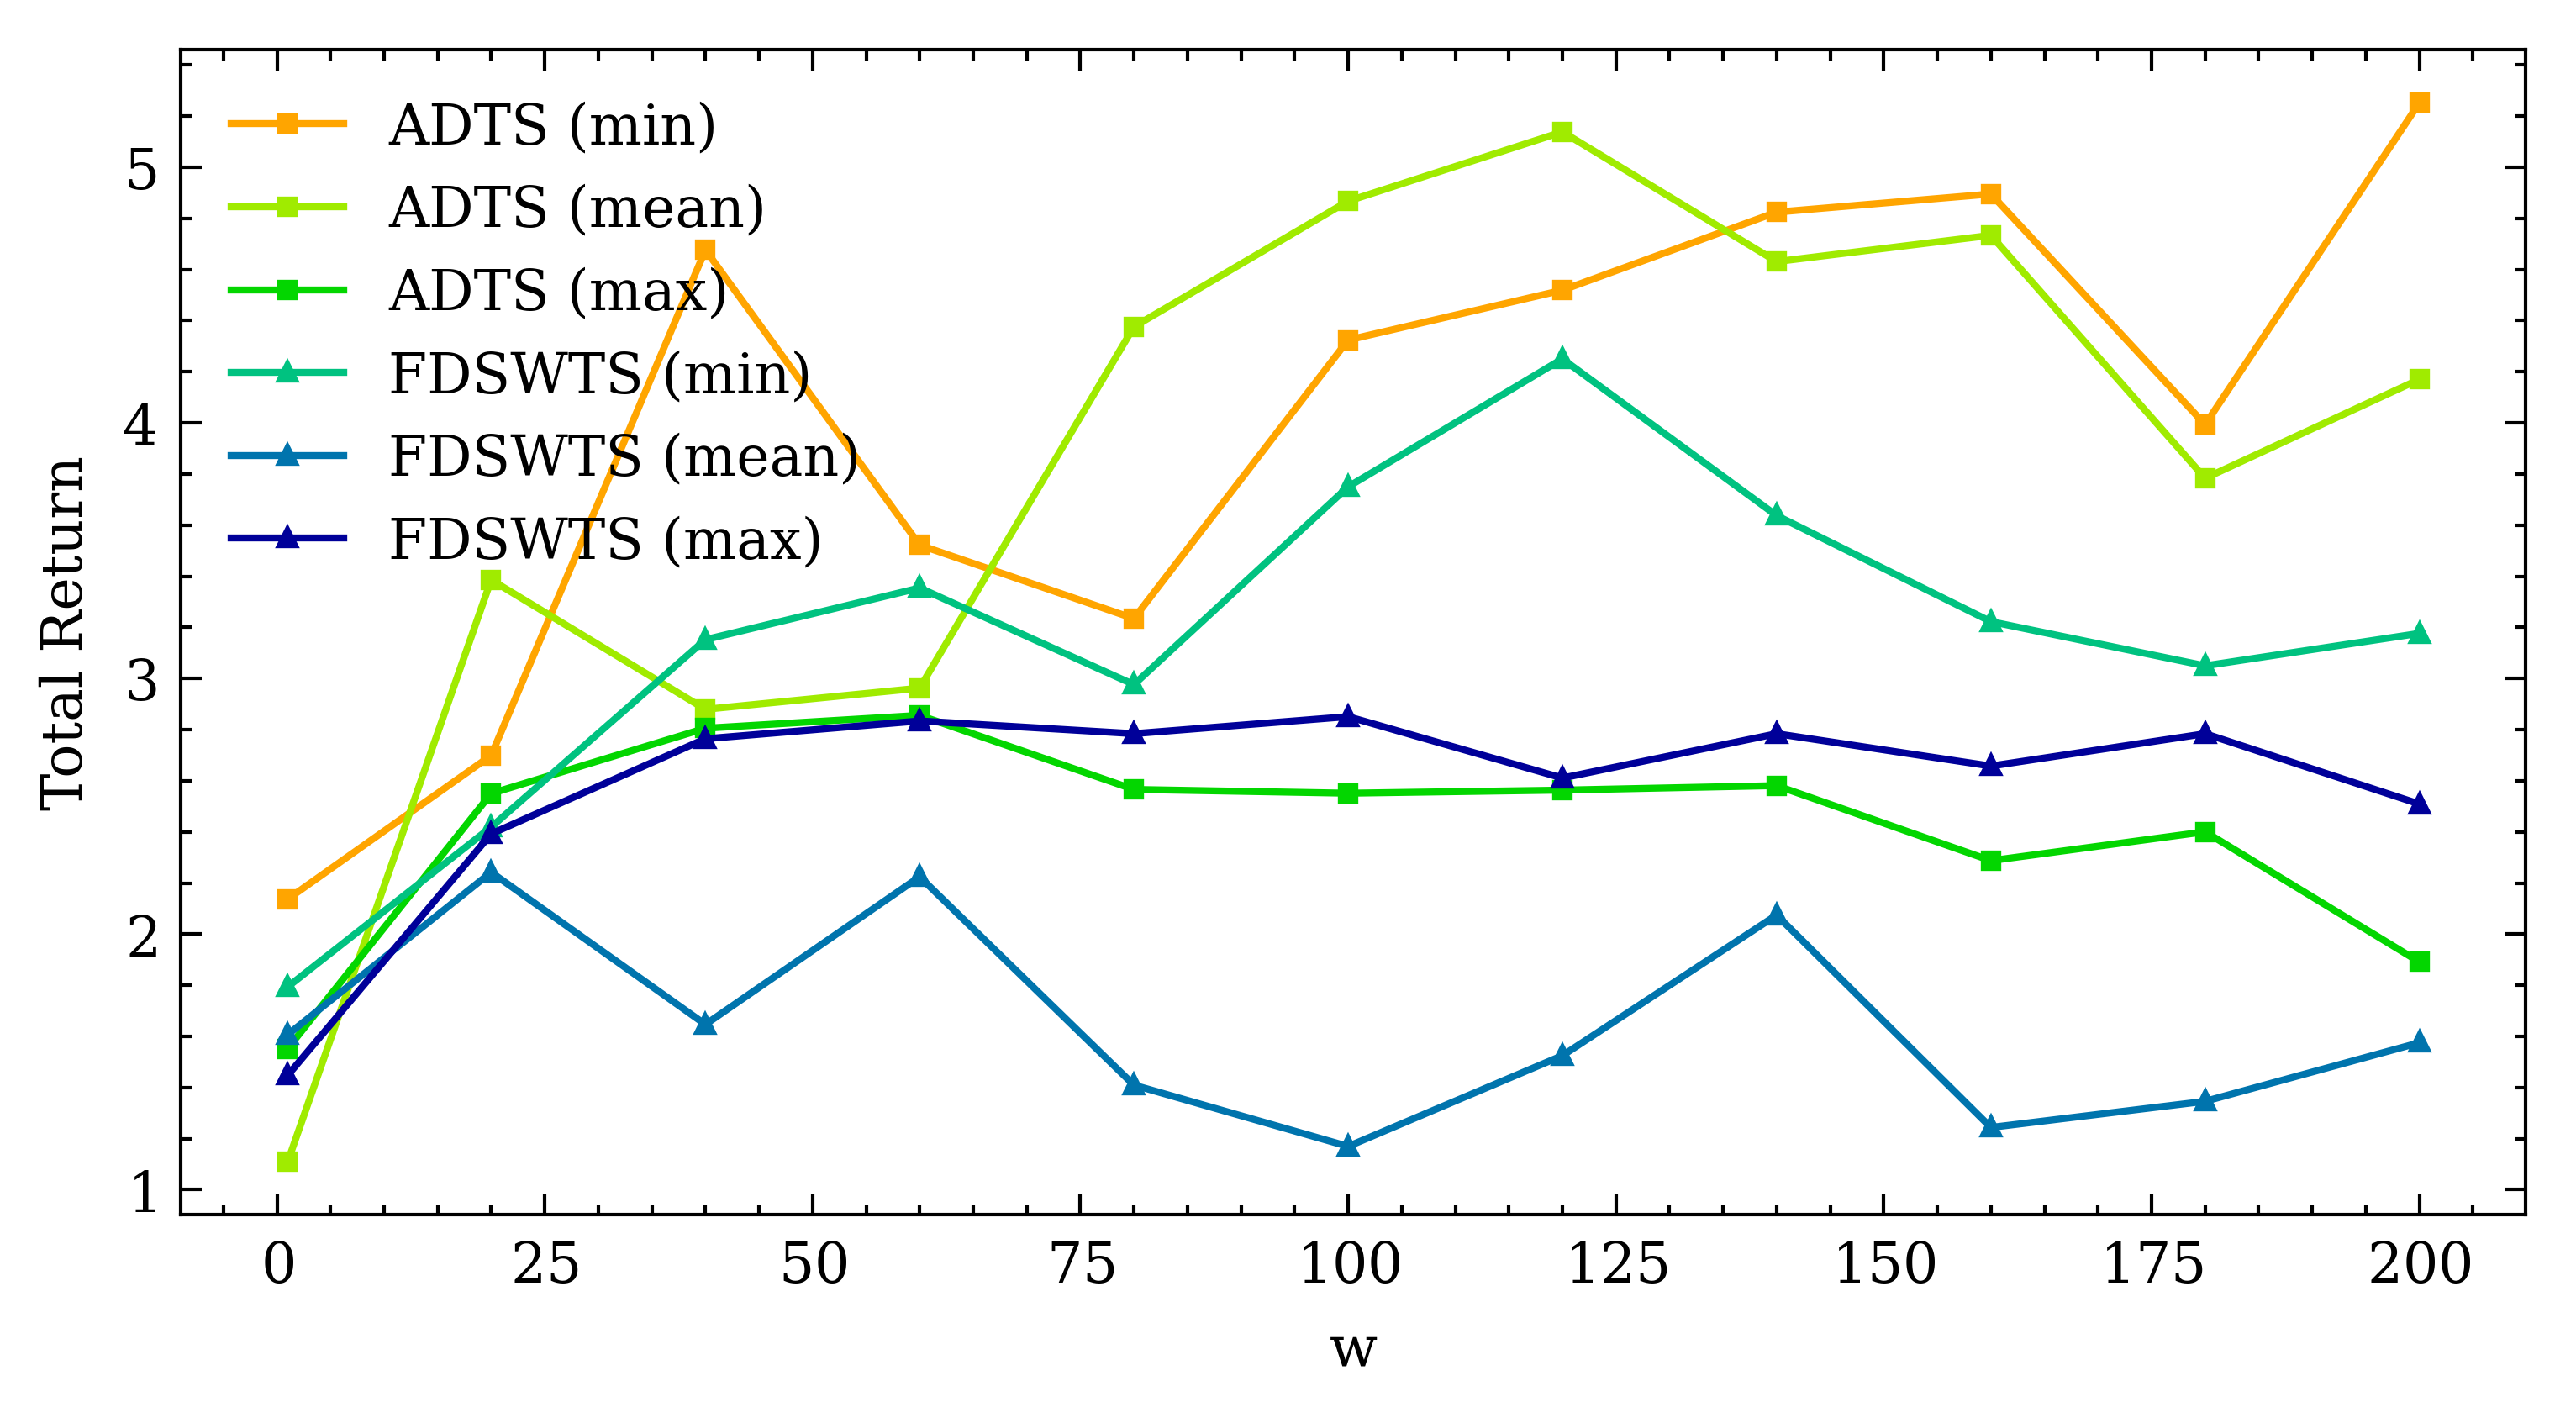

In [13]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    legend = []
    i = 0
    for policy in results_dict.keys():
        if len(results_dict[policy]['reward']) > 0:
            plt.plot(results_dict[policy]["w_vec"], results_dict[policy]["reward"], markers[i], markersize=2, label=policy, color=colors[i].rgb, linestyle="-")
            i+=1    
    plt.xlabel('w')
    plt.ylabel('Total Return')
    plt.legend()
    plt.savefig('04_effect_of_w_2.jpg', dpi=600)

## 3- Investigating the Rewards and Regrets

In [23]:
policies = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.95, "f": "min", "w": 100},
    },
    # "ADTS (max)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.95, "f": "max", "w": 30},
    # },
    "ADTS (mean)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 100},
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.7, "f": "min", "n": 125},
    },
    # "F-DSW TS (max)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 1.0, "f": "max", "n": 30},
    # },
    "F-DSW TS (mean)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.7, "f": "mean", "n": 125},
    },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
    },
    "Classical TS": {
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
    },
    "SW UCB": {
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 100},
    },
    "UCB1": {
        "policy_name": "UCB1",
        "args": {"n_arms": portfolio.shape[1]},
    },
    # "$\epsilon$-Greedy": {
    #     "policy_name": "EpsilonGreedy",
    #     "args": {"n_arms": portfolio.shape[1], "epsilon": 0.02},
    # },
}

In [24]:
from replay_engines.interface import BacktestInterface

crypto_bandit_backtester = BacktestInterface(
    bandit_policies=policies,
    n_simulations=50,
    reward_function="WindowedReturnArm",
    reward_function_args=dict(window=60),
    portfolio=portfolio,
)
crypto_bandit_backtester.run()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 979.01it/s]


In [110]:
from colour import Color
import numpy as np

blue = Color("orange", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(crypto_bandit_backtester.bandit_policies)))

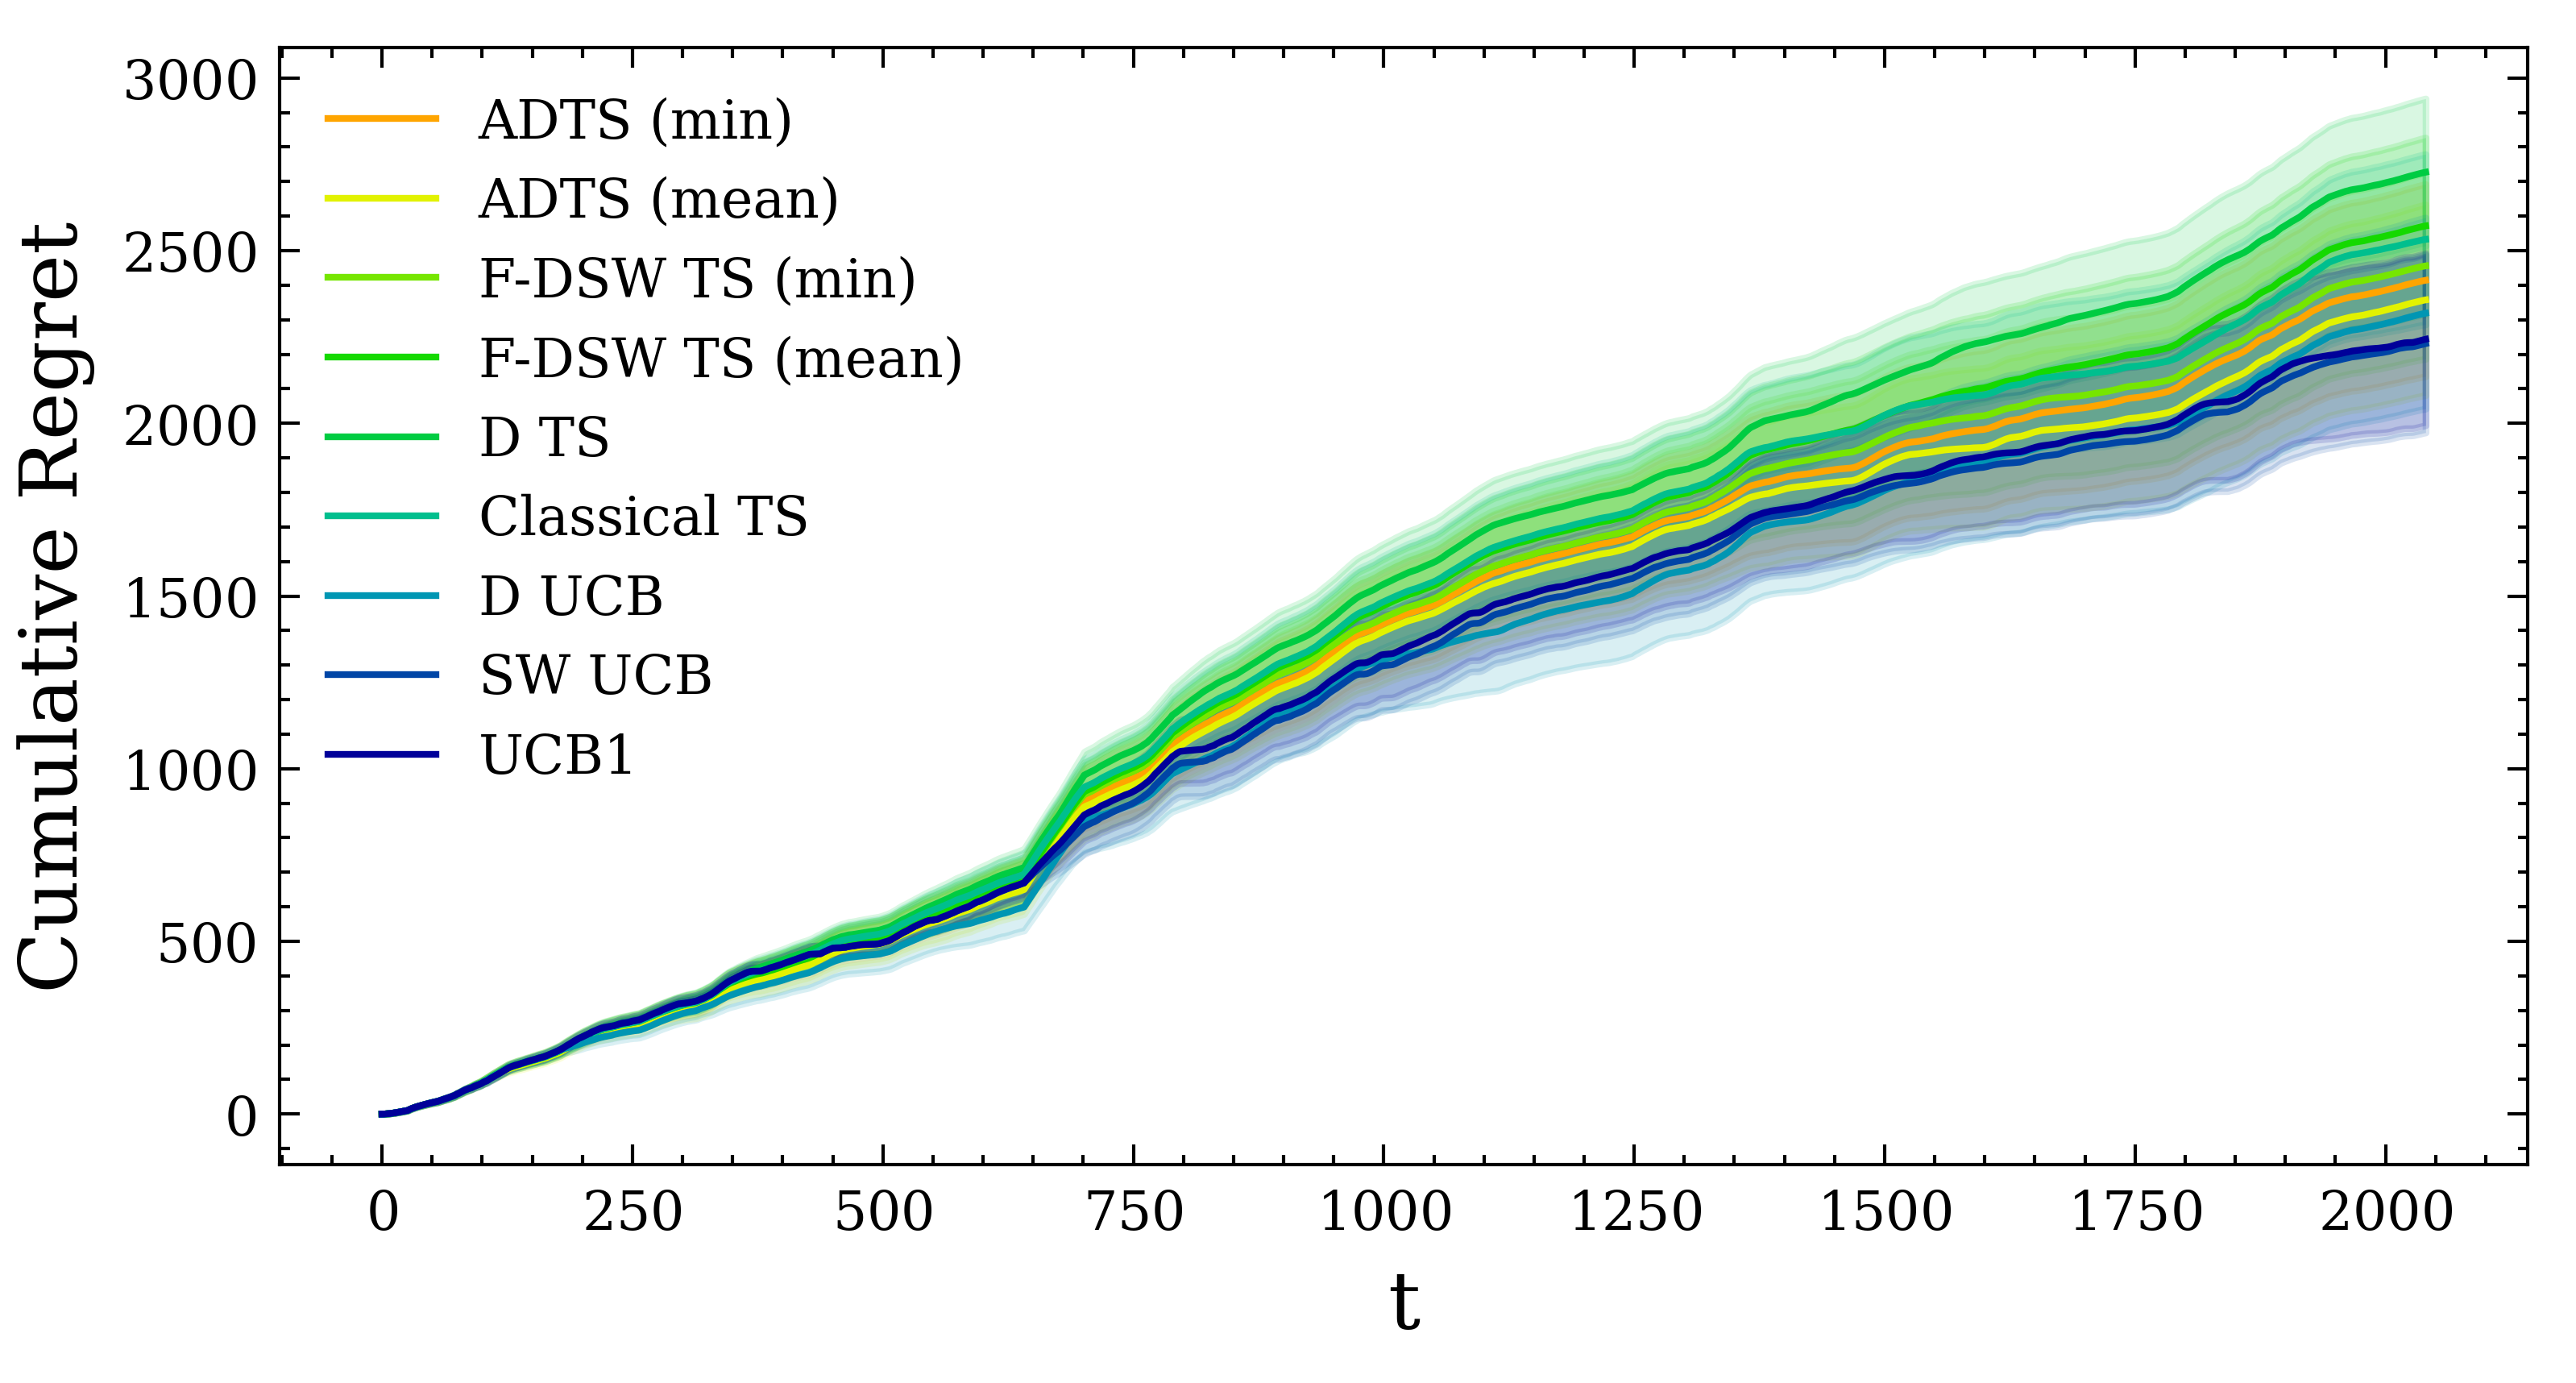

In [113]:
crypto_bandit_backtester.plot_regrets(
    save_fig=True,
    figure_name="02_cumulative_regrets.jpg",
    # plot_log=True,
    personalized_colors=[c.rgb for c in colors]
)

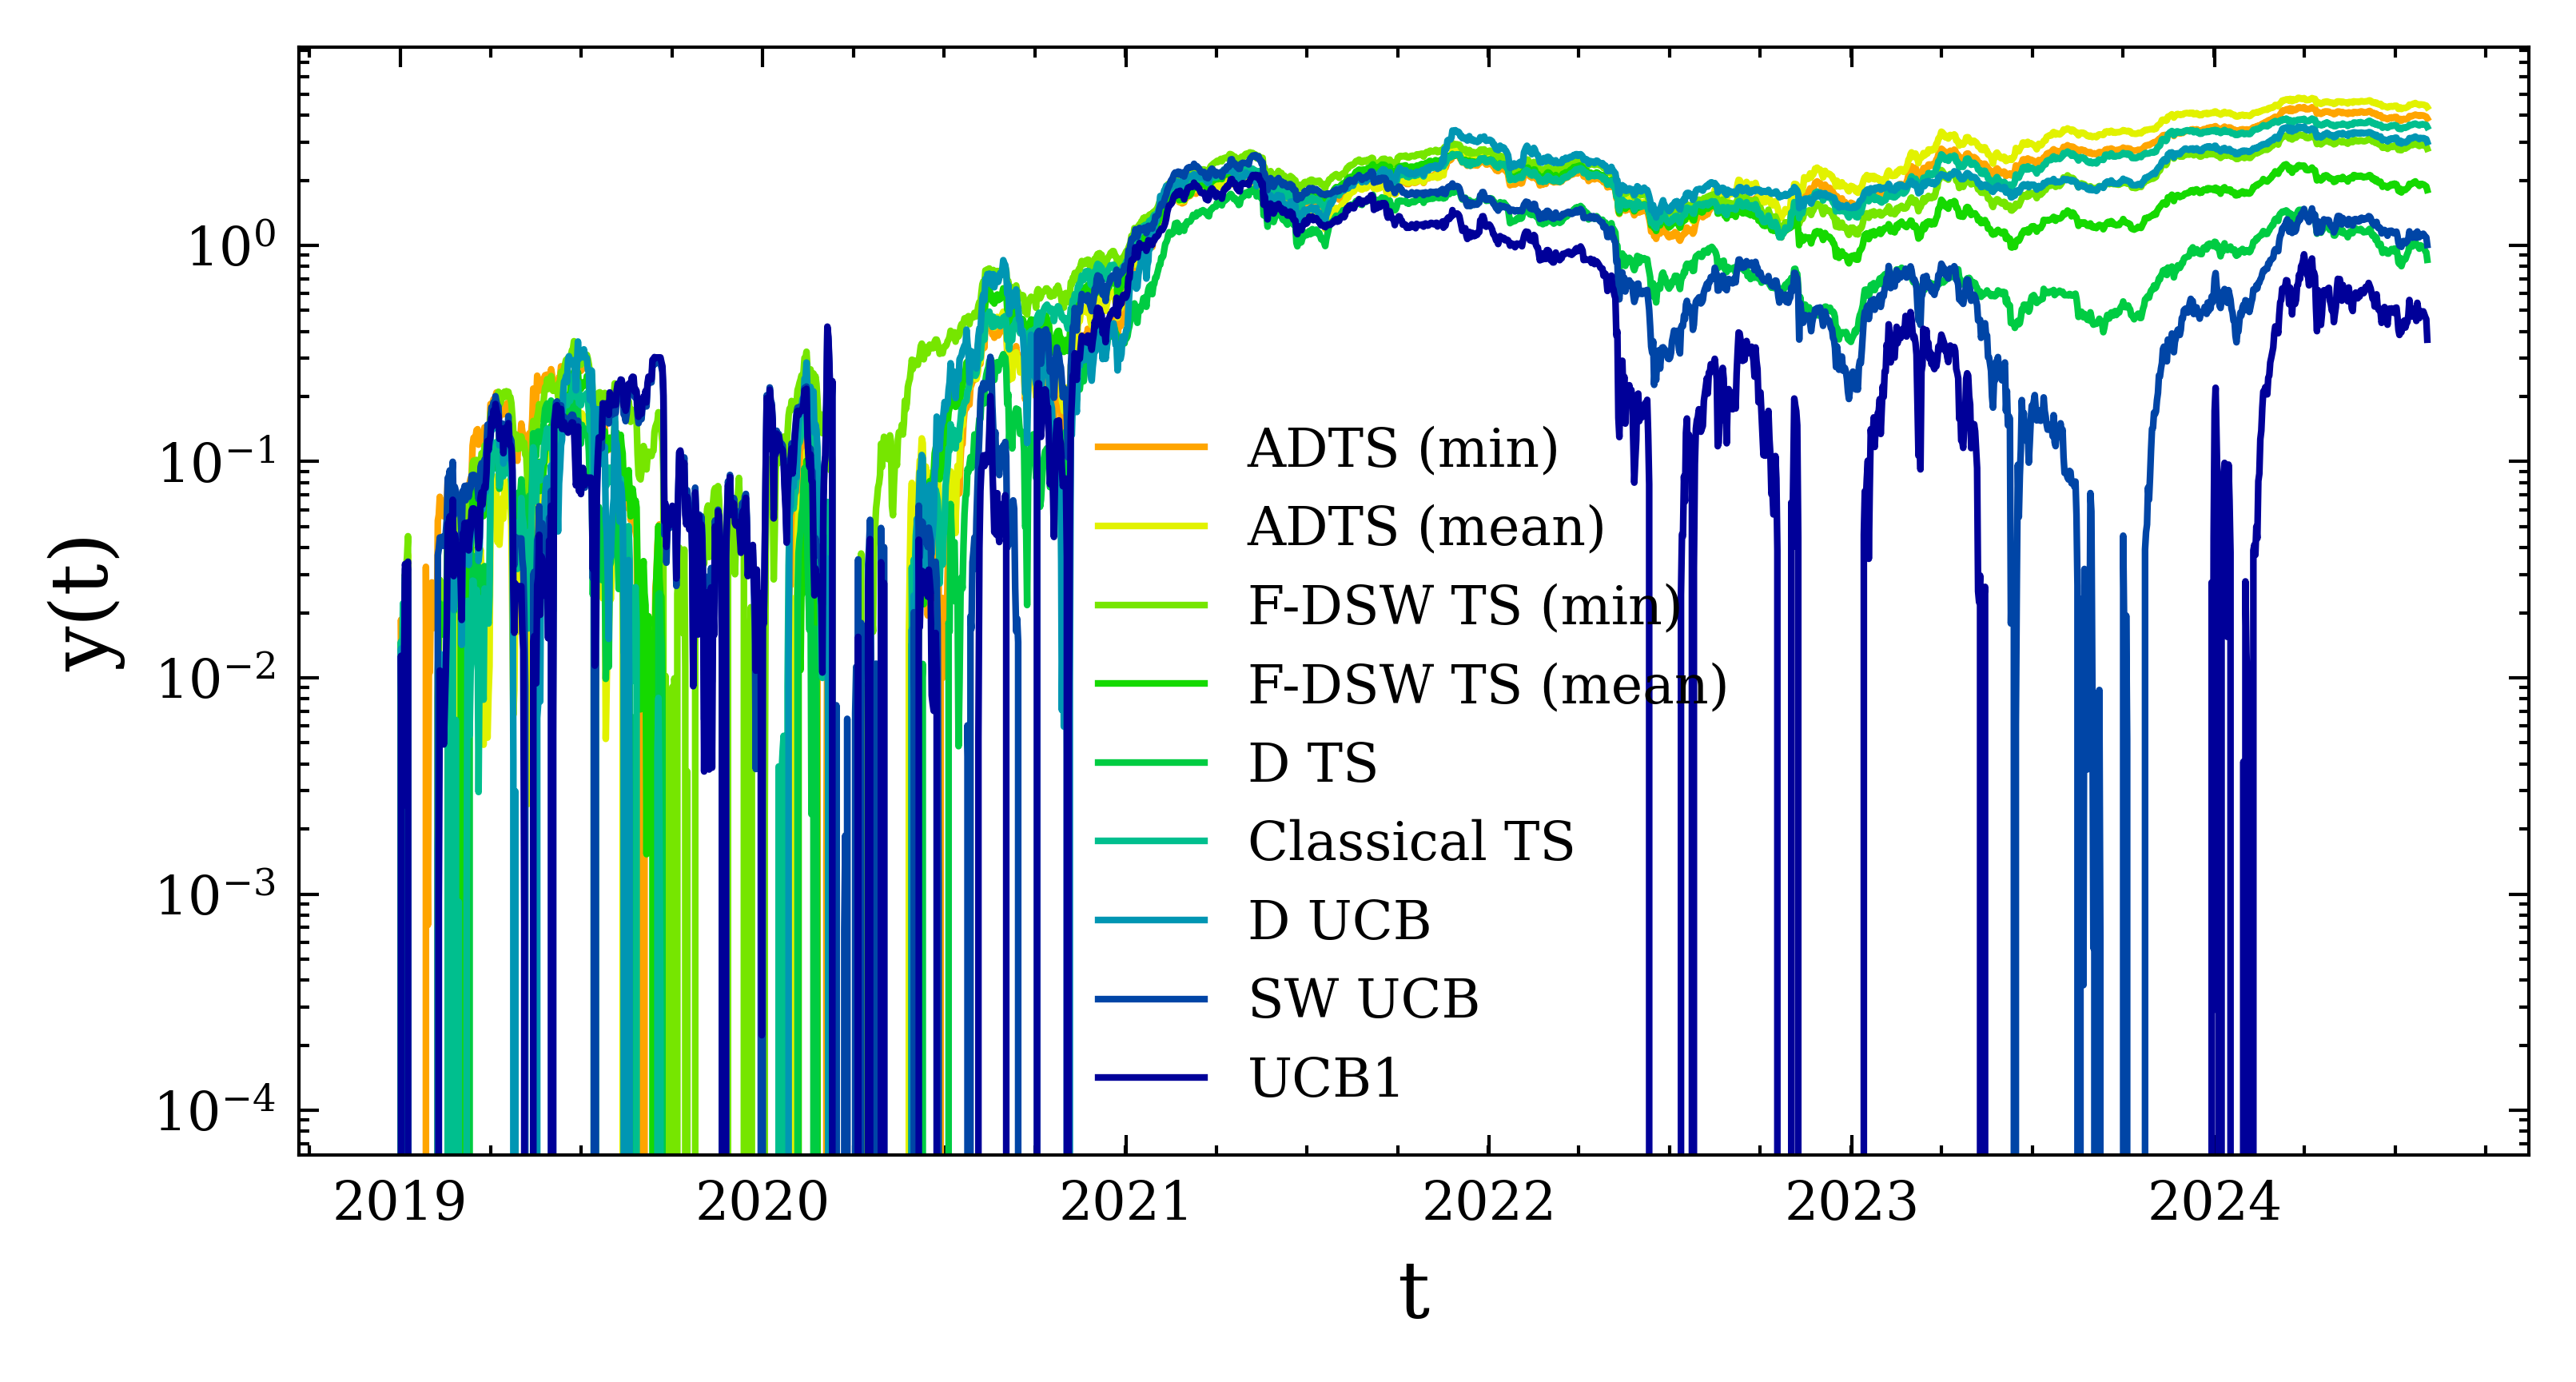

In [115]:
crypto_bandit_backtester.plot_rewards(
    # save_fig=True,
    # figure_name="03_rewards_versus_oracle.jpg",
    # oracle=portfolio.mean(axis=1).values,
    personalized_colors=[c.rgb for c in colors]
)
plt.yscale('log')

In [29]:
def calculate_metrics(log_returns):
    returns = np.exp(log_returns) - 1
    cumulative_returns = np.cumprod(1 + returns) - 1
    daily_returns = np.mean(returns)
    volatility = np.std(returns)
    drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))
    win_rate = np.sum(returns > 0) / len(returns)
    
    # Risk-adjusted ratios
    risk_free_rate = 0.0  # Assuming risk-free rate is zero
    excess_returns = returns - risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(365)
    downside_deviation = np.std(excess_returns[excess_returns < 0])
    sortino_ratio = np.mean(excess_returns) / downside_deviation
    calmar_ratio = np.mean(excess_returns) / drawdown
    
    return {
        "Cumulative Returns": cumulative_returns[-1],
        "Sharpe Ratio": sharpe_ratio,
        "Drawdown": drawdown,
#         "Average Daily Returns": daily_returns,
        "Volatility": volatility,
        # "Win Rate": win_rate,
        # "Sortino Ratio": sortino_ratio,
#         "Calmar Ratio": calmar_ratio
    }

In [30]:
def aggregate_metrics(policies: dict):
    portfolio_history = {}
    index = []
    for policy, output in policies.items():
        metrics_dict = calculate_metrics(output["mean_reward"])
        for k, v in metrics_dict.items():
            if k not in portfolio_history.keys():
                portfolio_history[k] = [v]
            else:
                portfolio_history[k].append(v)
        index.append(policy)
    df = pd.DataFrame(portfolio_history, index=index)
    df = df.sort_values("Cumulative Returns", ascending=False)
    return df

In [56]:
df_metrics = aggregate_metrics(crypto_bandit_backtester.bandit_policies)
df_metrics.to_csv('backtest_linear_bandits_crypto.csv')
df_metrics

Cumulative Returns  Sharpe Ratio   Drawdown  Volatility
ADTS (mean)               77.144321      1.365862 -51.019077    0.042447
ADTS (min)                46.687823      1.305821 -34.853910    0.038808
Classical TS              33.195755      1.244132 -15.878666    0.037481
D UCB                     19.223610      1.046627 -26.371327    0.046743
F-DSW TS (min)            15.454687      1.069814 -16.449743    0.036774
F-DSW TS (mean)            5.067055      0.827756 -11.844710    0.033885
SW UCB                     1.730390      0.621504 -12.820908    0.046045
D TS                       1.357223      0.561012  -4.764677    0.030085
UCB1                       0.442344      0.496262  -7.821816    0.045005

In [25]:
df = pd.read_csv("backtest_linear_bandits_crypto.csv")

In [27]:
df = df.drop(columns=["Volatility"], axis=1)

In [32]:
df = df.set_index("Unnamed: 0")

In [33]:
results_list

['ADTS (mean)',
 np.float64(77.1443212881538),
 np.float64(1.3658615787112398),
 np.float64(-51.01907733416722)]

In [34]:
import numpy as np

# Generate LaTeX table
table = "\\begin{table}[h]\n"
table += "\\centering\n"
table += "\\begin{tabular}{lcccccc}\n"
table += "\\hline\n"
table += "Policy & Cumulative Returns & SR & MDD \\\n"
table += "\\hline\n"
for i in range(len(df.index)):
    ticker=df.index[i]
    results_list = list(df.loc[ticker, :])
    results_list = [f"${abs(float(r)):.2f}$" for r in results_list]
    start_line = f"{ticker} & "
    end_line = "\\\\\n"
    table +=  start_line + " & ".join(results_list) + end_line
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\caption{Stocks Daily Risks and Returns}\n"
table += "\\end{table}\n"

print(table)

\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\hline
Policy & Cumulative Returns & SR & MDD \
\hline
ADTS (mean) & $77.14$ & $1.37$ & $51.02$\\
ADTS (min) & $46.69$ & $1.31$ & $34.85$\\
Classical TS & $33.20$ & $1.24$ & $15.88$\\
D UCB & $19.22$ & $1.05$ & $26.37$\\
F-DSW TS (min) & $15.45$ & $1.07$ & $16.45$\\
F-DSW TS (mean) & $5.07$ & $0.83$ & $11.84$\\
SW UCB & $1.73$ & $0.62$ & $12.82$\\
D TS & $1.36$ & $0.56$ & $4.76$\\
UCB1 & $0.44$ & $0.50$ & $7.82$\\
\hline
\end{tabular}
\caption{Stocks Daily Risks and Returns}
\end{table}



## 4- Investigating Bandit Networks

In [96]:
portfolio_size = 15

bandit_net_policies = {
    f"Two Stage ADTS (mean) | (n={portfolio_size})": {
        "sequential_policy_name": "AdaptiveDiscountedThompsonSampling",
        "sequential_policy_args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 100},
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 100},
        "combinatorial_agents": [],
        "agents": [],
        "chosen_superarms": []
    },
    f"ADTS (mean) + Classical TS | (n={portfolio_size})": {
        "sequential_policy_name": "AdaptiveDiscountedThompsonSampling",
        "sequential_policy_args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 160},
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
        "combinatorial_agents": [],
        "agents": [],
        "chosen_superarms": []
    },
    f"ADTS (mean) + f-DSW TS | (n={portfolio_size})": {
        "sequential_policy_name": "AdaptiveDiscountedThompsonSampling",
        "sequential_policy_args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 160},
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "min", "n": 160},
        "combinatorial_agents": [],
        "agents": [],
        "chosen_superarms": []
    },
    f"ADTS (mean) + SW UCB | (n={portfolio_size})": {
        "sequential_policy_name": "AdaptiveDiscountedThompsonSampling",
        "sequential_policy_args": {"n_arms": portfolio.shape[1], "gamma": 0.5, "f": "mean", "w": 30},
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 30},
        "combinatorial_agents": [],
        "agents": [],
        "chosen_superarms": []
    },
}

In [97]:
from replay_engines.interface import BanditNetworkBacktestInterface

bandit_backtester = BanditNetworkBacktestInterface(
    bandit_policies=bandit_net_policies,
    portfolio_size=portfolio_size,
    n_simulations=50,
    reward_function="WindowedReturnArm",
    reward_function_args=dict(window=120),
    portfolio=portfolio,
)
bandit_backtester.run()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 28.57it/s]
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/min_dsw_ts.py:33: RuntimeWarning: invalid value encountered in scalar divide
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))


In [98]:
blue = Color("orange", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(bandit_backtester.bandit_policies)))

In [79]:
import yfinance as yf
import re

def fetch_crypto_index_data(start_date=None, end_date=None, interval='1d'):
    """
    Fetch historical data for the CMC Crypto 200 Index from Yahoo Finance.

    Args:
        start_date (str): Start date in 'YYYY-MM-DD' format (default: None, fetches all data).
        end_date (str): End date in 'YYYY-MM-DD' format (default: None, fetches up to the latest data).
        interval (str): Data interval. Options: '1d', '1wk', '1mo' (default: '1d').

    Returns:
        pd.DataFrame: DataFrame containing historical data for the index.
    """
    benchmarks = ["^CMC200"]
    yf_obj = yf.Tickers(re.sub(r"'|,|\[|\]", "", str(benchmarks)))
    
    
    try:
        df_benchmarks = pd.DataFrame()
        for ticker in yf_obj.tickers.keys():
            if ticker not in df_benchmarks.columns:
                print(ticker)
                df_ticker = yf_obj.tickers[ticker].history(start=start_date, end=end_date)
                df_ticker["ticker"] = ticker
                df_ticker["return"] = np.log(df_ticker["Close"] / df_ticker["Close"].shift(1))
                df_ticker["return"] = df_ticker["return"].fillna(0)
                df_ticker = df_ticker.reset_index()
                df_ticker = df_ticker[["Date", "ticker", "return"]]
                df_benchmarks = pd.concat([df_benchmarks, df_ticker])
        df_benchmarks = df_benchmarks.pivot_table(values="return", index="Date", columns="ticker")
        df_benchmarks = df_benchmarks.fillna(0.)
        df_benchmarks = df_benchmarks.drop_duplicates()
        return df_benchmarks
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [80]:
# Example usage:
data = fetch_crypto_index_data(start_date="2019-01-01", end_date="2025-01-16", interval="1d")

^CMC200


In [81]:
data = data.reset_index()
data.Date = pd.to_datetime(data.Date).dt.date
data = data.set_index("Date")

In [44]:
dates = pd.date_range('2019-01-01', '2024-08-02')
len_dates = len(dates)
cmc_index = pd.DataFrame(
    {
        "^CMC200": np.zeros(len_dates)
    },
    index=dates
)

df_merge = cmc_index.merge(data, left_index=True, right_index=True, how='left')
df_merge = df_merge.fillna(0.)
df_merge['CMC 200'] = df_merge['^CMC200_x'] + df_merge['^CMC200_y']

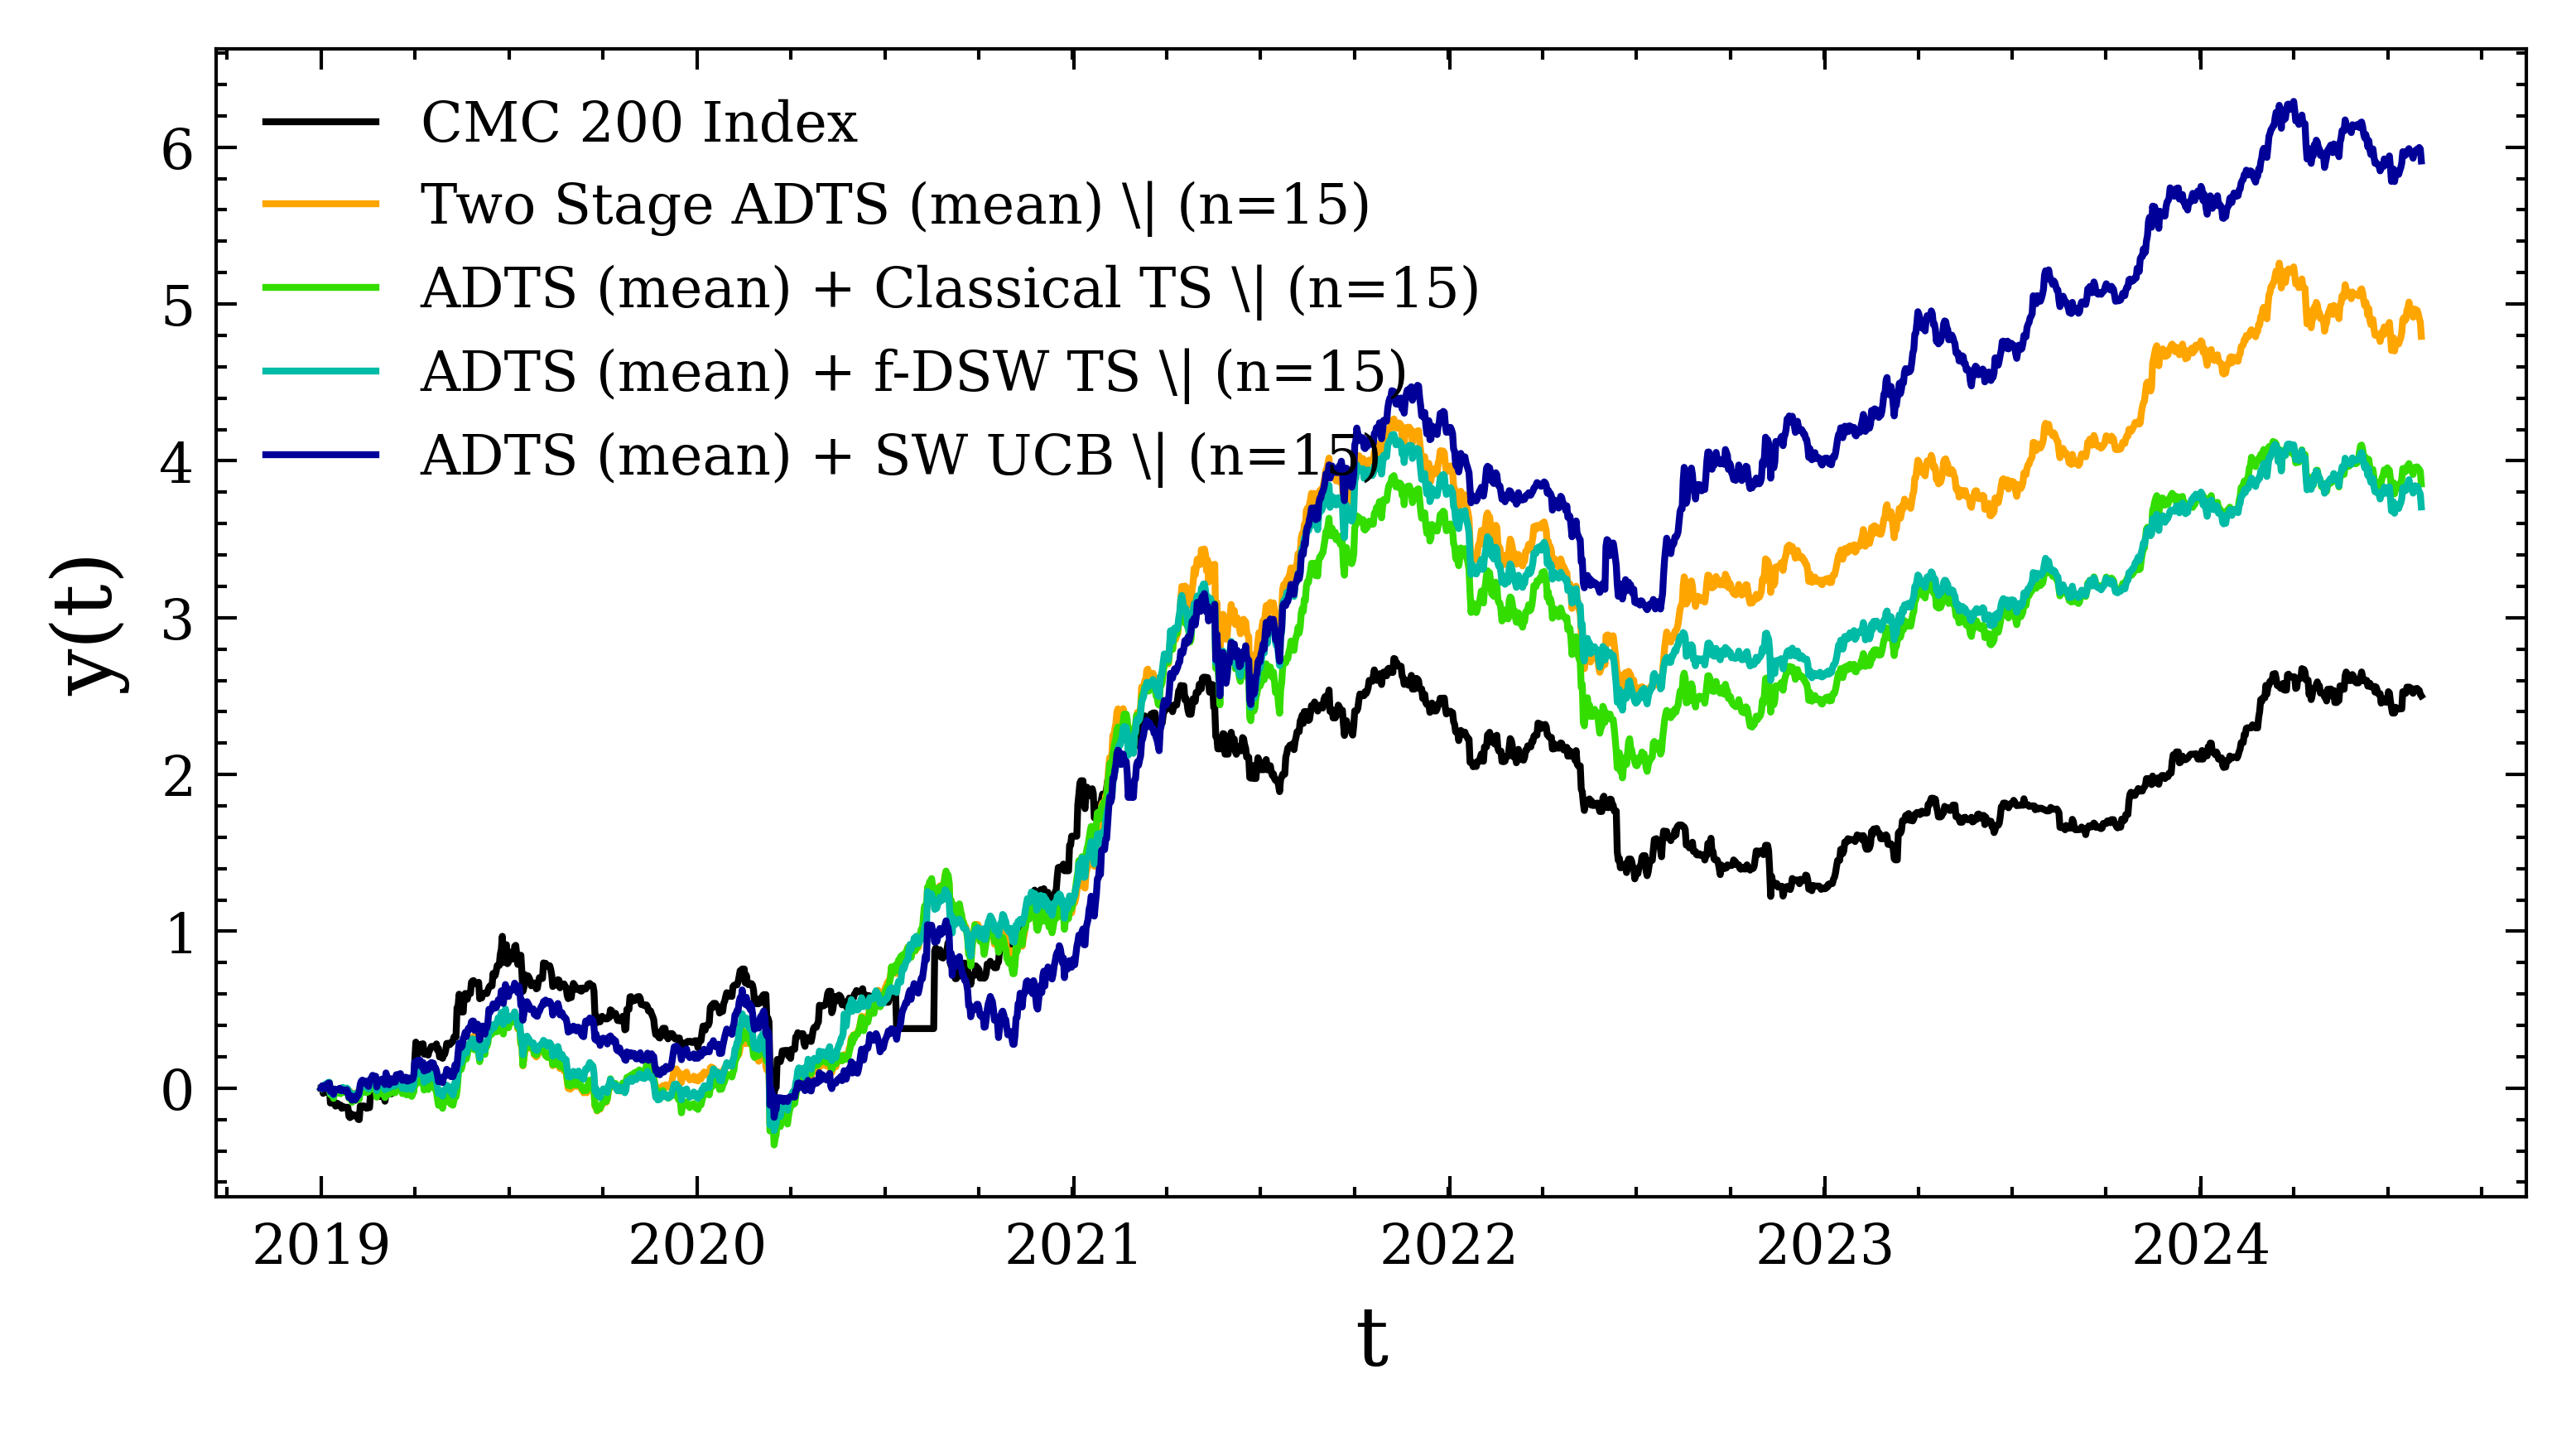

In [95]:
bandit_backtester.plot_rewards(
    # save_fig=True,
    # figure_name="03_rewards_versus_oracle_portfolio.jpg",
    oracle=df_merge['CMC 200'].values,
    oracle_name='CMC 200 Index',
    personalized_colors=[c.rgb for c in colors]
)
# ax = plt.gca()
# ax.legend(['a'])
# plt.plot(data[['^CMC200']].cumsum())
# plt.show()

In [107]:
from portfolio.classical import MarkovitzPortfolio, EqualWeightsPortfolio, RiskParityPortfolio, CAPMPortfolio
from pandas import DataFrame


def calculate_classical_portfolios(portfolio: DataFrame, adjust_frequency: int = 30) -> DataFrame:
    """
    This function calculates the equal weights, risk parity, Markowitz, and Black-Litterman portfolios.
    """
    equal_weights = EqualWeightsPortfolio(portfolio_log_returns=portfolio, adjust_frequency=adjust_frequency).run_backtest()
    risk_parity = RiskParityPortfolio(portfolio_log_returns=portfolio, adjust_frequency=adjust_frequency).run_backtest()
    markowitz = MarkovitzPortfolio(portfolio_log_returns=portfolio, adjust_frequency=adjust_frequency).run_backtest()
    capm = CAPMPortfolio(portfolio_log_returns=portfolio, adjust_frequency=adjust_frequency).run_backtest()
    return pd.DataFrame({
        "Equal Weights": equal_weights,
        "Risk Parity": risk_parity,
        "Markowitz": markowitz,
        "CAPM": capm,
    })

In [108]:
df_classical = calculate_classical_portfolios(portfolio=portfolio)

LinAlgError: Singular matrix

In [89]:
classical_policies = {}

df_classical = calculate_classical_portfolios(portfolio=portfolio)
for col in df_classical.columns:
    classical_policies[col] = {
        "mean_reward": df_classical[col].fillna(0.).values
    }
classical_policies['CMC 200'] = {'mean_reward': df_merge['CMC 200'].values}

In [90]:
unified_policies = bandit_backtester.bandit_policies.copy()
unified_policies.update(classical_policies)

In [91]:
df_metrics = aggregate_metrics(unified_policies)
# df_metrics.to_csv('backtest_bandit_networks_crypto.csv')
df_metrics

Cumulative Returns  Sharpe Ratio  \
ADTS (mean) + SW UCB | (n=15)                336.545784      1.685033   
Two Stage ADTS (mean) | (n=15)               133.028116      1.512842   
ADTS (mean) + f-DSW TS | (n=15)               45.331817      1.300067   
ADTS (mean) + Classical TS | (n=15)           43.241222      1.275675   
CMC 200                                       11.203004      0.972218   
CAPM                                           3.310451      0.736197   
Equal Weights                                  2.474711      0.685935   
Risk Parity                                    0.101102      0.316613   

                                       Drawdown  Volatility  
ADTS (mean) + SW UCB | (n=15)       -196.714841    0.042902  
Two Stage ADTS (mean) | (n=15)       -89.891079    0.041276  
ADTS (mean) + f-DSW TS | (n=15)      -64.660003    0.039084  
ADTS (mean) + Classical TS | (n=15)  -44.129938    0.040370  
CMC 200                              -12.087418    0.037343  
CAPM                                 -10.959045    0.037218  
Equal Weights                         -5.946756    0.029020  
Risk Parity                           -0.097983    0.003146

In [ ]:
import requests
import pandas as pd
from datetime import datetime

def fetch_crypto_indices():
    """
    Fetches a list of cryptocurrency indices from the CoinGecko API.

    Returns:
        pd.DataFrame: A dataframe containing indices details.
    """
    url = "https://api.coingecko.com/api/v3/indexes"

    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        indices = response.json()

        # Normalize JSON data into a Pandas DataFrame
        df = pd.json_normalize(indices)

        # Keep relevant columns
        columns_to_keep = [
            "name",
            "id",
            "market",
            "last",
            "is_multi_asset_composite",
            "constituents",
        ]

        # Filter available columns based on API response
        df = df[[col for col in columns_to_keep if col in df.columns]]

        return df

    except requests.exceptions.RequestException as e:
        print(f"Error fetching indices: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

def fetch_historical_data(index_id, days="max"):
    """
    Fetches historical price data for a specific cryptocurrency index.

    Args:
        index_id (str): The ID of the index to fetch data for.
        days (str): Number of days to fetch data for (e.g., '1', '30', 'max').

    Returns:
        pd.DataFrame: A dataframe containing historical price data.
    """
    url = f"https://api.coingecko.com/api/v3/indexes/{index_id}/history?days={days}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        if "prices" in data:
            # Extract and format price data
            prices = data["prices"]
            df = pd.DataFrame(prices, columns=["timestamp", "price"])
            df["date"] = pd.to_datetime(df["timestamp"], unit="ms")
            df.drop("timestamp", axis=1, inplace=True)
            return df

        else:
            print("No historical price data found for this index.")
            return pd.DataFrame()

    except requests.exceptions.RequestException as e:
        print(f"Error fetching historical data for index {index_id}: {e}")
        return pd.DataFrame()

In [ ]:
# Fetch indices
df_indices = fetch_crypto_indices()
if not df_indices.empty:
    print("Fetched Cryptocurrency Indices:")
    print(df_indices)

    # Example: Fetch historical data for the first index in the list
    first_index_id = df_indices.loc[0, "id"]
    historical_data = fetch_historical_data(first_index_id, days="30")

    if not historical_data.empty:
        print(f"Historical Data for Index {first_index_id}:")
        print(historical_data)
else:
    print("No indices found or an error occurred.")


In [ ]:
df_indices